In [1]:
import argparse
import logging
import os
import time

import torch.nn as nn
import torch.optim as optim
from torch.backends import cudnn
from torch.utils.tensorboard import SummaryWriter

from models.preact_resnet import PreActResNet18
from models.resnet import ResNet18
from utils.util import *
from utils.deepfool import *
import math
import matplotlib.pyplot as plt
import copy
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [2]:
torch.manual_seed(0)
device='cuda'
dataset_path='./data'
CHECKPOINT_DIR = '../../../../scratch/pekang/checkpoint/'


transform_test = transforms.Compose([
    transforms.ToTensor(),
])
testset = datasets.CIFAR10(root=dataset_path, train=False, download=True, transform=transform_test)
subsetA, _ = torch.utils.data.random_split(testset, [5, 9995], generator=torch.Generator().manual_seed(6666666666))
testloadersingle = torch.utils.data.DataLoader(subsetA, batch_size=1, shuffle=False)

normalize = Normalize(cifar10_mu, cifar10_std)

Files already downloaded and verified


In [3]:
# Draw the cross-section of decision boundary around a specific input by giving two vectors
def draw_decision_boundary(model, inputs, targets, e1_grad, e1_grad_norm, e2_grad, e2_grad_norm, palette, ax, label1, label2):
    
    cos = cal_cos_similarity(e1_grad, e2_grad, e1_grad_norm, e2_grad_norm)
    angle = math.acos(cos)
    matrix = np.array([[1, -1 / math.tan(angle)], [0, 1 / math.sin(angle)]])
    r_matrix = np.linalg.inv(matrix)
    e1 = e1_grad / e1_grad_norm
    e2 = e2_grad / e2_grad_norm
    
    print(f'e1_grad_norm {round(e1_grad_norm.item(), 2)}, e2_grad_norm {round(e2_grad_norm.item(), 2)}, angle {round(angle / math.pi * 180, 2)}, cos {round(cos.item(), 2)}')
    x_indices = np.linspace(-1.5, 2.5, 128)
    y_indices = np.linspace(-1.5, 2.5, 128)
    x_array = np.outer(np.linspace(-1.5, 2.5, 128), np.ones(128)) 
    y_array = x_array.copy().T 
    label_list = []
    for x_ind in x_indices:
        perturbed_intputs = []
        for y_ind in y_indices:
            new_index = np.matmul(matrix, [x_ind, y_ind])
            new_inputs = inputs + new_index[0] * e1 + new_index[1] * e2
            perturbed_intputs.append(new_inputs)

        perturbed_intputs_cat = torch.cat(perturbed_intputs, dim=0)
        perturbed_outputs = model(normalize(perturbed_intputs_cat))

        t = torch.zeros(perturbed_intputs_cat.shape[0], dtype=torch.long).fill_(targets.item()).to(device)
        perturbed_loss = F.cross_entropy(perturbed_outputs, t, reduction='none').detach()
        label_list.append(perturbed_outputs.max(dim=1)[1].cpu().numpy()[None,:])
    label_array = np.concatenate(label_list)
    colors = np.empty(label_array.shape, dtype='<U7')
    for ix,iy in np.ndindex(label_array.shape):
        colors[ix,iy] = palette[label_array[ix,iy]]

    e1_xy = np.matmul(r_matrix, np.array([e1_grad_norm.item(), 0]))
    e2_xy = np.matmul(r_matrix, np.array([0, e2_grad_norm.item()]))
    points = np.concatenate((e1_xy[None, :], e2_xy[None, :]))
    x_e1 = np.linspace(0, e1_xy[0], 100)
    y_e1 = np.linspace(0, e1_xy[1], 100)
    x_e2 = np.linspace(0, e2_xy[0], 100)
    y_e2 = np.linspace(0, e2_xy[1], 100)
    
    ax.scatter(x_array.flatten(), y_array.flatten(), s=1, c=colors.flatten(), marker=',')
    ax.plot(x_e1, y_e1, 'black')
    ax.plot(x_e2, y_e2, 'black')

    for i, txt in enumerate([label1, label2]):
        text = ax.annotate(txt, (points[i, 0], points[i, 1]))
        text.set_fontsize(16)

# Draw the cross-section of decision boundary spaned by $DF^2$ perturbation and FGSM

In [4]:
def draw_fgsm(loader, epoch, resumed_model_name='0226_cifar10_none_w_proj_eps_8', epsilon_num=8, train_fgsm_ratio=1):
    resumed_model_name = resumed_model_name + f'_{epoch}.pth'
    print('======================' + resumed_model_name + '======================')
    epsilon = epsilon_num / 255.
    model = PreActResNet18()
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)
    model = model.to(device)
    checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, resumed_model_name))
    model.load_state_dict(checkpoint['model'])
    model.eval()

    for batch_idx, (inputs, targets) in enumerate(loader):
        print('input image index', batch_idx)

        inputs, targets = inputs.to(device), targets.to(device)

        loop, perturbation50 = deepfool_train(model, inputs, normalize, overshoot=0.02, max_iter=50, norm_dist='l_2', device=device, random_start=False, early_stop=True)
        perturbation50_norm = perturbation50.view(perturbation50.shape[0], -1).norm(dim=1)

        zero = torch.zeros_like(inputs).to(device)
        zero.requires_grad = True
        output = model(normalize(inputs + zero))
        loss = F.cross_entropy(output, targets)
        loss.backward()
        grad_input = zero.grad.detach()
        fgsm_delta = train_fgsm_ratio * epsilon * torch.sign(grad_input)
        fgsm_delta = clamp(fgsm_delta, lower_limit - inputs, upper_limit - inputs).detach()
        fgsm_delta_norm = fgsm_delta.view(fgsm_delta.shape[0], -1).norm(dim=1)

        fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
        
        # different red colors to represent different class
        palette = {0: '#d71d1d', 1: '#e22828', 2: '#e43a3a', 3: '#e74b4b', 4: '#e95d5d', 5: '#eb6f6f', 6: '#ee8181', 7: '#f09393', 8: '#f3a5a5', 9: '#f5b7b7'}
        
        # set the true class to be green
        palette[targets.item()] = '#6ec26e'
        
        print(f"between df50 and fgsm")
        draw_decision_boundary(model, inputs, targets, perturbation50, perturbation50_norm, fgsm_delta, fgsm_delta_norm, palette, ax1, '$\mathrm{DF}^2$', 'FGSM')
        plt.show()
        print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
#         plt.close()

======================0226_cifar10_none_w_proj_eps_8_15.pth======================
input image index 0
between df50 and fgsm
e1_grad_norm 0.04, e2_grad_norm 1.67, angle 60.9, cos 0.49


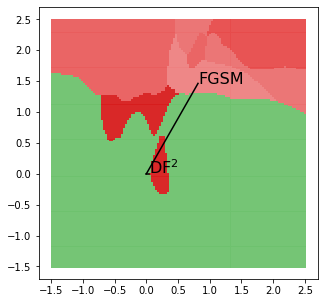

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
input image index 1
between df50 and fgsm
e1_grad_norm 0.01, e2_grad_norm 1.74, angle 126.92, cos -0.6


In [ ]:
resumed_model_name = '0226_cifar10_none_w_proj_eps_8'
epoch = 15
draw_fgsm(testloadersingle, epoch, resumed_model_name=resumed_model_name, epsilon_num=8, train_fgsm_ratio=1)

# Draw the cross-section of decision boundary spaned by  $DF^2$  perturbation and $DF^{\infty}-1$

In [ ]:
def draw_df(loader, epoch, resumed_model_name='0226_cifar10_deepfool_8', epsilon_num=8, train_overshoot=0.02):
    resumed_model_name = resumed_model_name + f'_{epoch}.pth'
    print('======================' + resumed_model_name + '======================')
    epsilon = epsilon_num / 255.
    model = PreActResNet18()
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)
    model = model.to(device)
    checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, resumed_model_name))
    model.load_state_dict(checkpoint['model'])
    model.eval()

    for batch_idx, (inputs, targets) in enumerate(loader):
        print('input image index', batch_idx)
        inputs, targets = inputs.to(device), targets.to(device)

        loop, perturbation50 = deepfool_train(model, inputs, normalize, overshoot=0.02, max_iter=50, norm_dist='l_2', device=device, random_start=False, early_stop=True)
        perturbation50_norm = perturbation50.view(perturbation50.shape[0], -1).norm(dim=1)

        _, perturbation = deepfool_train(model, inputs, normalize, overshoot=train_overshoot, max_iter=1, norm_dist='l_inf', device=device, random_start=False, early_stop=False)
        perturbation = torch.clamp(perturbation, min=-epsilon, max=epsilon)
        perturbation = clamp(perturbation, lower_limit - inputs, upper_limit - inputs).detach()
        perturbation_norm = perturbation.view(perturbation.shape[0], -1).norm(dim=1)

        fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
        palette = {0: '#d71d1d', 1: '#e22828', 2: '#e43a3a', 3: '#e74b4b', 4: '#e95d5d', 5: '#eb6f6f', 6: '#ee8181', 7: '#f09393', 8: '#f3a5a5', 9: '#f5b7b7'}
        palette[targets.item()] = '#6ec26e'
        print(f"between df50 and df")
        draw_decision_boundary(model, inputs, targets, perturbation50, perturbation50_norm, perturbation, perturbation_norm, palette, ax1, '$\mathrm{DF}^2$', '$\mathrm{DF}^{\infty}$-1')
        plt.show()
        print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
#         plt.close()

In [ ]:
resumed_model_name = '0226_cifar10_deepfool_8'
epoch = 70
draw_df(testloadersingle, epoch, resumed_model_name=resumed_model_name, epsilon_num=8, train_overshoot=0.02)